In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

tf.random.set_seed(42)
np.random.seed(42)

igneous_rock_properties = {
   "Diamond":     {"velocity": (7.0, 0.1), "amplitude": (0.85, 0.02), "duration": (320, 10), "frequency_Hz": (55, 5)},
    "Corundum":    {"velocity": (6.8, 0.1), "amplitude": (0.82, 0.02), "duration": (310, 10), "frequency_Hz": (52, 5)},
    "Zircon":      {"velocity": (6.9, 0.1), "amplitude": (0.84, 0.02), "duration": (315, 10), "frequency_Hz": (53, 5)},
    "Spinel":      {"velocity": (6.7, 0.1), "amplitude": (0.80, 0.02), "duration": (310, 10), "frequency_Hz": (51, 5)},
    "Topaz":       {"velocity": (6.8, 0.1), "amplitude": (0.83, 0.02), "duration": (320, 10), "frequency_Hz": (54, 5)}
}

def generate_dataset(props, samples_per_class=800, seed=42):
    """Generate dataset with more samples for better training"""
    np.random.seed(seed)
    data = []

    for rock_type, features in props.items():
        for _ in range(samples_per_class):
            row = {
                "rock_type": rock_type,
                "velocity": np.random.normal(*features["velocity"]),
                "amplitude": np.random.normal(*features["amplitude"]),
                "duration": np.random.normal(*features["duration"]),
                "frequency_Hz": np.random.normal(*features["frequency_Hz"])
            }
            data.append(row)

    df = pd.DataFrame(data)
    df = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    return df

df = generate_dataset(igneous_rock_properties)

df['velocity_x_amplitude'] = df['velocity'] * df['amplitude']
df['velocity_squared'] = df['velocity'] ** 2
df['duration_squared'] = df['duration'] ** 2
df['amplitude_duration'] = df['amplitude'] * df['duration']
df['velocity_frequency'] = df['velocity'] * df['frequency_Hz']
df['amplitude_frequency'] = df['amplitude'] * df['frequency_Hz']
df['duration_frequency'] = df['duration'] * df['frequency_Hz']
df['velocity_duration'] = df['velocity'] * df['duration']
df['amplitude_squared'] = df['amplitude'] ** 2
df['frequency_squared'] = df['frequency_Hz'] ** 2
df['velocity_amplitude_ratio'] = df['velocity'] / df['amplitude']
df['duration_frequency_ratio'] = df['duration'] / df['frequency_Hz']
df['velocity_duration_ratio'] = df['velocity'] / df['duration']
df['velocity_cubed'] = df['velocity'] ** 3
df['amplitude_cubed'] = df['amplitude'] ** 3

print(df)

     rock_type  velocity  amplitude    duration  frequency_Hz  \
0      Diamond  6.964166   0.837049  327.441920     54.093879   
1        Topaz  6.817872   0.826524  329.959549     57.681137   
2      Diamond  6.967138   0.862064  314.558860     54.186035   
3        Topaz  6.831816   0.838273  310.513781     54.365521   
4       Spinel  6.838487   0.807933  301.668585     56.329819   
...        ...       ...        ...         ...           ...   
3995  Corundum  6.751229   0.841487  314.964001     62.375325   
3996  Corundum  6.669841   0.782940  308.751131     52.078489   
3997  Corundum  6.814552   0.807718  311.409827     59.943135   
3998     Topaz  6.873976   0.859704  331.176324     56.509260   
3999    Spinel  6.842326   0.797332  296.135106     48.380784   

      velocity_x_amplitude  velocity_squared  duration_squared  \
0                 5.829349         48.499608     107218.210787   
1                 5.635132         46.483372     108873.304163   
2                 6.0

In [15]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['rock_type'])
feature_cols = [
    'velocity', 'amplitude', 'duration', 'frequency_Hz',
    'velocity_x_amplitude', 'velocity_squared', 'duration_squared',
    'amplitude_duration', 'velocity_frequency', 'amplitude_frequency',
    'duration_frequency', 'velocity_duration', 'amplitude_squared',
    'frequency_squared', 'velocity_amplitude_ratio', 'duration_frequency_ratio',
    'velocity_duration_ratio', 'velocity_cubed', 'amplitude_cubed'
]

X = df[feature_cols].values
y = df['label'].values

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [16]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights_dict = dict(enumerate(class_weights))

def create_model(input_dim, num_classes, dropout_rate=0.3):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),

        # First block
        tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),

        # Second block
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),

        # Third block
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate * 0.5),

        # Fourth block
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate * 0.5),

        # Output layer
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    return model

model = create_model(X_scaled.shape[1], len(le.classes_))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=20,
        restore_best_weights=True,
        monitor='val_accuracy',
        min_delta=0.001
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.3,
        patience=8,
        min_lr=1e-6,
        monitor='val_accuracy',
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "Gem and Rare Minerals_model.keras",
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1
    )
]

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 512)            │        10,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,885 (730.02 KB)

 Trainable params: 184,965 (722.52 KB)

 Non-trainable params: 1,920 (7.50 KB)

In [18]:
print("Training improved model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=150,  # More epochs with early stopping
    batch_size=64,  # Larger batch size for stability
    callbacks=callbacks,
    class_weight=class_weights_dict,
    verbose=1
)

Training improved model...
Epoch 1/150
48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3909 - loss: 2.2325
Epoch 1: val_accuracy improved from -inf to 0.48500, saving model to Gem and Rare Minerals_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.3950 - loss: 2.2201 - val_accuracy: 0.4850 - val_loss: 1.9718 - learning_rate: 0.0010
Epoch 2/150
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4994 - loss: 1.8570
Epoch 2: val_accuracy did not improve from 0.48500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5000 - loss: 1.8551 - val_accuracy: 0.4450 - val_loss: 1.9348 - learning_rate: 0.0010
Epoch 3/150
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5131 - loss: 1.8008
Epoch 3: val_accuracy did not improve from 0.48500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5136 - loss: 1.7992 - val_accuracy: 0.4688 - val_loss: 1.8695 - learning_rate: 0.0010
Epoch 4/150
47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5258 - loss: 1.7761
Epoch 4:

In [19]:
model = tf.keras.models.load_model("Gem and Rare Minerals_model.keras")

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

accuracy = np.mean(y_pred == y_test)
print(f"\nFinal Test Accuracy: {accuracy:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  

Classification Report:
              precision    recall  f1-score   support

    Corundum       0.48      0.49      0.48       160
     Diamond       0.64      0.72      0.68       160
      Spinel       0.69      0.76      0.72       160
       Topaz       0.51      0.54      0.52       160
      Zircon       0.46      0.31      0.37       160

    accuracy                           0.56       800
   macro avg       0.55      0.56      0.56       800
weighted avg       0.55      0.56      0.56       800


Final Test Accuracy: 0.5650


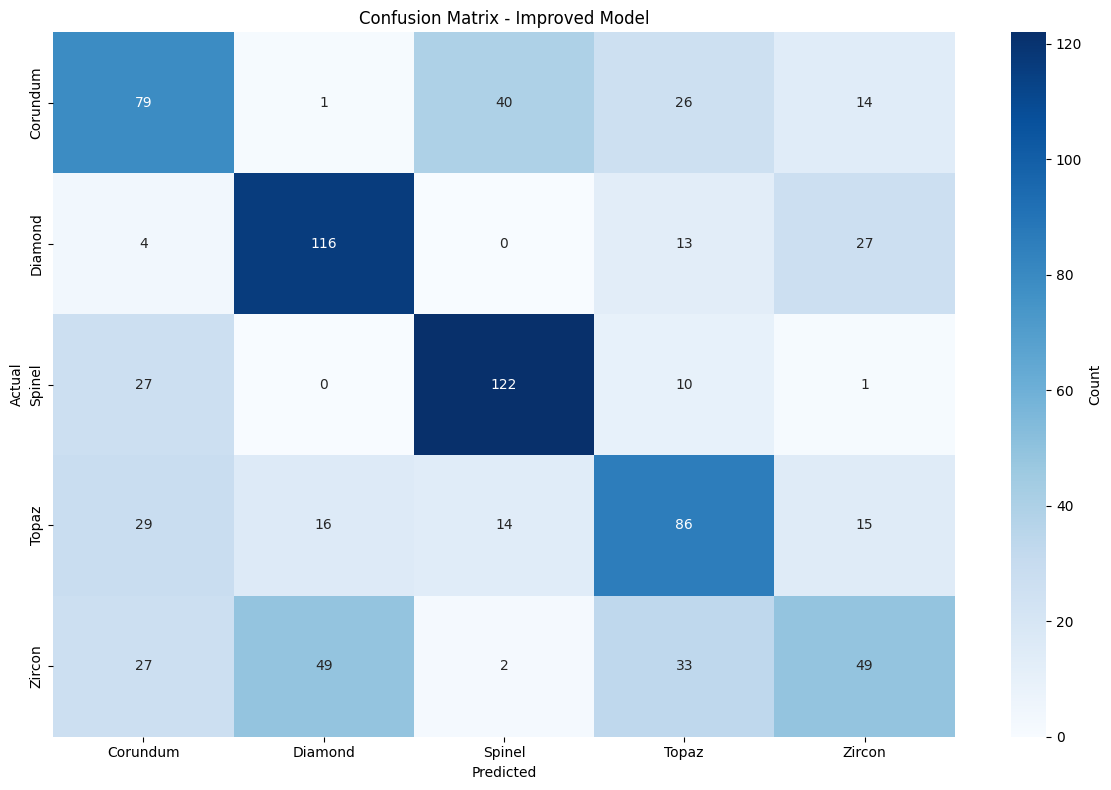

In [20]:
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_,
            cmap='Blues', cbar_kws={'label': 'Count'})
plt.title("Confusion Matrix - Improved Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

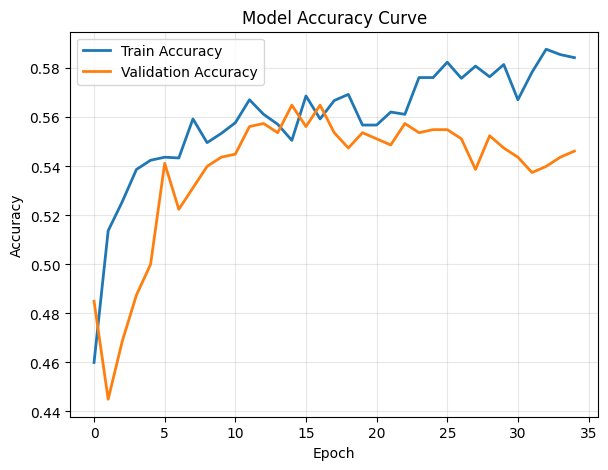

In [21]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title("Model Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

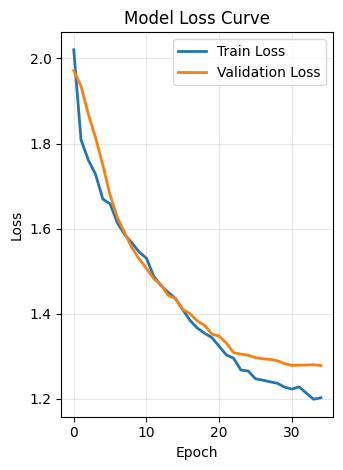

In [22]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title("Model Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Calculating feature importance...


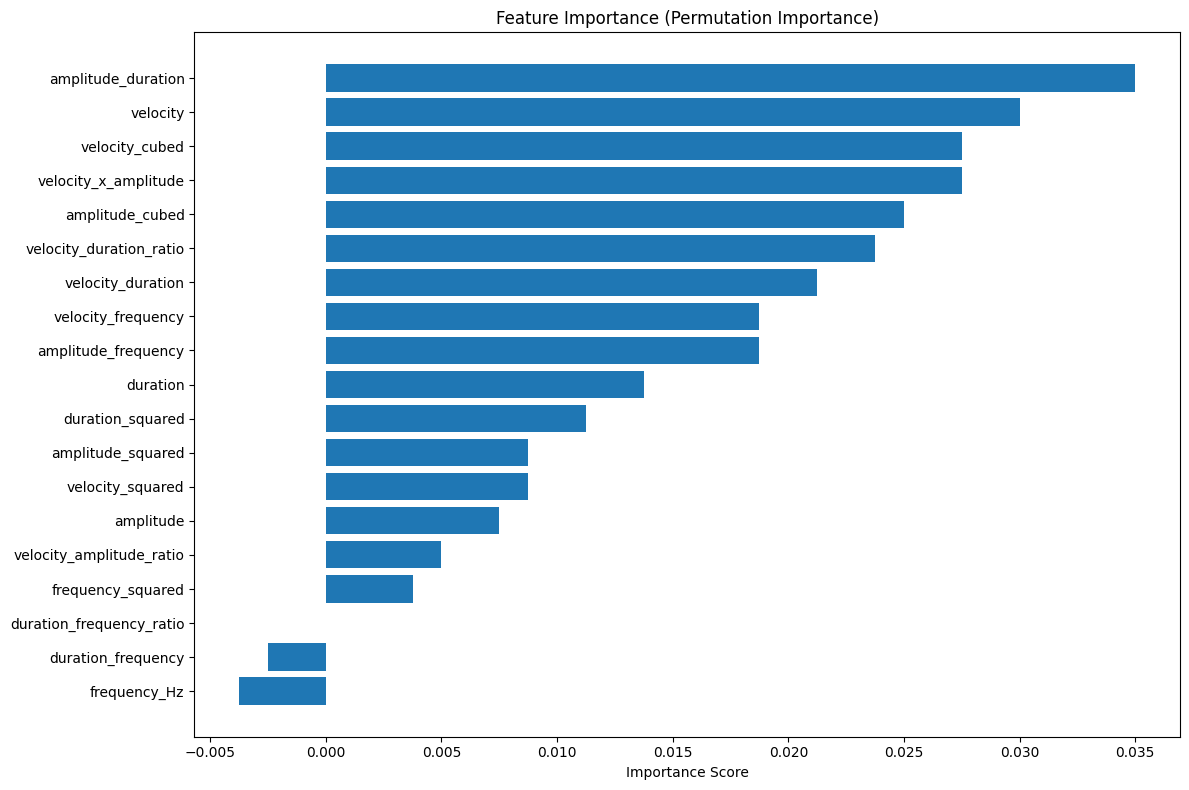

In [23]:
def get_feature_importance(model, X_test, feature_names):
    """Calculate feature importance using permutation importance"""
    baseline_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    importance_scores = []
    for i, feature in enumerate(feature_names):
        X_test_permuted = X_test.copy()
        np.random.shuffle(X_test_permuted[:, i])
        permuted_accuracy = model.evaluate(X_test_permuted, y_test, verbose=0)[1]
        importance = baseline_accuracy - permuted_accuracy
        importance_scores.append(importance)
    return importance_scores
print("\nCalculating feature importance...")
importance_scores = get_feature_importance(model, X_test, feature_cols)
plt.figure(figsize=(12, 8))
feature_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importance_scores
}).sort_values('importance', ascending=True)

plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.title('Feature Importance (Permutation Importance)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

In [24]:
joblib.dump(scaler, "Gem and Rare Minerals_scaler.pkl")
joblib.dump(le, "Gem and Rare Minerals_label_encoder.pkl")
print(f"\nModel saved as: Gem and Rare Minerals_model.keras")
print(f"Scaler saved as: Gem and Rare Minerals_scaler.pkl")
print(f"Label encoder saved as: Gem and Rare Minerals_label_encoder.pkl")
print(f"Final accuracy: {accuracy:.4f}")



Model saved as: Gem and Rare Minerals_model.keras
Scaler saved as: Gem and Rare Minerals_scaler.pkl
Label encoder saved as: Gem and Rare Minerals_label_encoder.pkl
Final accuracy: 0.5650


In [26]:
import numpy as np
from tensorflow.keras.models import load_model
import joblib
model = load_model("Gem and Rare Minerals_model.keras")
scaler = joblib.load("Gem and Rare Minerals_scaler.pkl")
le = joblib.load("Gem and Rare Minerals_label_encoder.pkl")
def engineer_features(velocity, amplitude, duration, frequency_hz):
    features = [velocity, amplitude, duration, frequency_hz]
    velocity_x_amplitude = velocity * amplitude
    velocity_squared = velocity ** 2
    duration_squared = duration ** 2
    amplitude_duration = amplitude * duration
    velocity_frequency = velocity * frequency_hz
    amplitude_frequency = amplitude * frequency_hz
    duration_frequency = duration * frequency_hz
    velocity_duration = velocity * duration
    amplitude_squared = amplitude ** 2
    frequency_squared = frequency_hz ** 2
    velocity_amplitude_ratio = velocity / amplitude
    duration_frequency_ratio = duration / frequency_hz
    velocity_duration_ratio = velocity / duration
    velocity_cubed = velocity ** 3
    amplitude_cubed = amplitude ** 3
    all_features = [
        velocity, amplitude, duration, frequency_hz,
        velocity_x_amplitude, velocity_squared, duration_squared,
        amplitude_duration, velocity_frequency, amplitude_frequency,
        duration_frequency, velocity_duration, amplitude_squared,
        frequency_squared, velocity_amplitude_ratio, duration_frequency_ratio,
        velocity_duration_ratio, velocity_cubed, amplitude_cubed
    ]
    return np.array(all_features).reshape(1, -1)
def predict_rock_type(velocity, amplitude, duration, frequency_hz, verbose=True):
    sample_features = engineer_features(velocity, amplitude, duration, frequency_hz)
    sample_scaled = scaler.transform(sample_features)
    pred_prob = model.predict(sample_scaled, verbose=0)
    pred_index = np.argmax(pred_prob)
    pred_label = le.inverse_transform([pred_index])[0]
    confidence = np.max(pred_prob)
    if verbose:
        print(f"\n🪨 Input Sample:")
        print(f"   Velocity: {velocity} km/s")
        print(f"   Amplitude: {amplitude}")
        print(f"   Duration: {duration} ms")
        print(f"   Frequency: {frequency_hz} Hz")
        print(f"\n📊 Prediction Results:")
        print(f"   Predicted Rock Type: {pred_label}")
        print(f"   Confidence: {confidence:.3f}")
        print(f"\n📈 All Probabilities:")
        for i, rock_type in enumerate(le.classes_):
            print(f"   {rock_type}: {pred_prob[0][i]:.3f}")
    return pred_label, confidence, pred_prob[0]
if __name__ == "__main__":
    velocity = 7.01
    amplitude = 0.86
    duration = 321
    frequency_hz = 54.6


    rock_type, confidence, probabilities = predict_rock_type(
        velocity, amplitude, duration, frequency_hz
    )
    print(f"\nFinal Result: {rock_type} (Confidence: {confidence:.3f})")


🪨 Input Sample:
   Velocity: 7.01 km/s
   Amplitude: 0.86
   Duration: 321 ms
   Frequency: 54.6 Hz

📊 Prediction Results:
   Predicted Rock Type: Diamond
   Confidence: 0.656

📈 All Probabilities:
   Corundum: 0.008
   Diamond: 0.656
   Spinel: 0.004
   Topaz: 0.054
   Zircon: 0.278

Final Result: Diamond (Confidence: 0.656)
